# Liquid freshwater content (LFWC) in the SPNA and NSEA from ECCOv4r4

In [1]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load salinity from ECCOv4r4

In [2]:
ecco = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_interp_salt.nc')

### Set spatial and temporal range

In [3]:
south,north,west,east = 40,90,-110,45

tstart = '1992-01-01'
tend = '2017-12-31'

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [6]:
D = 700
psal_ref = 35.0

In [7]:
psal = ecco.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east),depth=slice(0,D))

In [8]:
f = (psal_ref - psal)/psal_ref

In [11]:
h_fw = (f * ecco.dz.sel(depth=slice(0,D))).sum('depth')

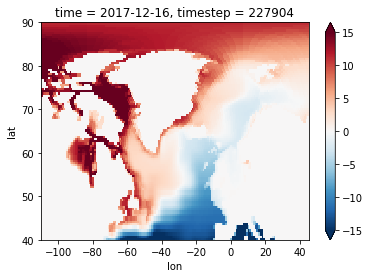

In [14]:
h_fw[-1].plot(vmin=-15)

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

In [15]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [16]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [17]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:

In [18]:
h_fw_spna = h_fw.salem.roi(shape=gdf_spna.loc[[0]])
h_fw_nsea = h_fw.salem.roi(shape=gdf_nsea.loc[[0]])

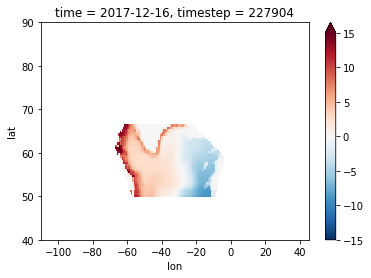

In [22]:
h_fw_spna[-1].plot(vmin=-15)

In [23]:
Vfw_spna = (h_fw_spna * ecco.area).sum(dim=['lat','lon'])
Vfw_nsea = (h_fw_nsea * ecco.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
Vfw_spna = Vfw_spna*1e-9
Vfw_nsea = Vfw_nsea*1e-9

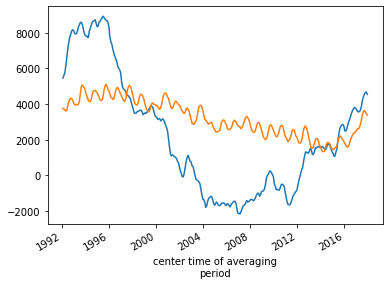

In [24]:
Vfw_spna.plot()
Vfw_nsea.plot()

In [27]:
lfwc_anom = Vfw_spna - Vfw_spna.mean('time')

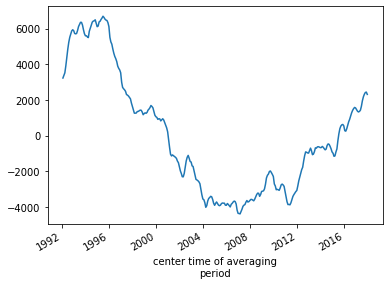

In [28]:
lfwc_anom.plot()

In [29]:
df = lfwc_anom.to_dataframe(name='lfwc')

In [31]:
# Save with index column (time)
df.to_csv('/mnt/efs/data/eccov4r4_lfwc_spna_upper700m_monthly.csv', index=True)